### Imports

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# Initial Definitions
DATA_PATH = "./full_data.json"
SAVED_MODEL_PATH = "model.h5"
EPOCHS = 40
BATCH_SIZE = 32
PATIENCE = 5
LEARNING_RATE = 0.0001

In [2]:
# Import the dataset.
#training_df = pd.read_json(path_or_buf="./full_data2.json")
# Scale the label.
#training_df["median_house_value"] /= 1000.0
#training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
# Print the first rows of the pandas DataFrame.
#training_df.head()
def load_data(data_path):
    """Loads training dataset from json file.
    :param data_path (str): Path to json file containing data
    :return X (ndarray): Inputs
    :return y (ndarray): Targets
    """
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return X, y

In [3]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.2):
    """Creates train, validation and test sets.
    :param data_path (str): Path to json file containing data
    :param test_size (flaot): Percentage of dataset used for testing
    :param validation_size (float): Percentage of train set used for cross-validation
    :return X_train (ndarray): Inputs for the train set
    :return y_train (ndarray): Targets for the train set
    :return X_validation (ndarray): Inputs for the validation set
    :return y_validation (ndarray): Targets for the validation set
    :return X_test (ndarray): Inputs for the test set
    :return X_test (ndarray): Targets for the test set
    """
    #load the data, forgot to add back in...
    X, y = load_data(data_path)
    # create train, validation, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)
    # add an axis to nd array
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [4]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):
    """Build neural network using keras.
    :param input_shape (tuple): Shape of array representing a sample train. E.g.: (44, 13, 1)
    :param loss (str): Loss function to use
    :param learning_rate (float):
    :return model: TensorFlow model
    """
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()
    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape,
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                     kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))
    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)
    # softmax output layer
    model.add(tf.keras.layers.Dense(110, activation='softmax'))
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)
    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])
    # print model parameters on console
    model.summary()
    return model

In [5]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

In [6]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """
    fig, axs = plt.subplots(2)
    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")
    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")
    plt.show()

Training sets loaded!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 85, 11, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 85, 11, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 6, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 4, 32)         18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 41, 4, 32)         128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None

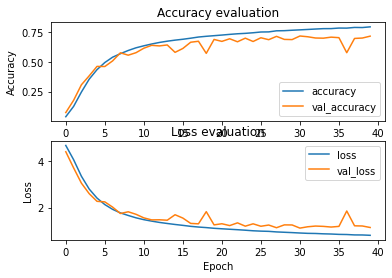

272/272 [==============================] - 5s 17ms/step - loss: 1.1508 - accuracy: 0.7131

Test loss: 1.1507854461669922, test accuracy: 71.31364345550537


In [7]:
# generate train, validation and test sets
X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)
# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation)
# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)
# evaluate network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))
# save model
model.save(SAVED_MODEL_PATH)

### JALEN YOUR TESTING GOES HERE:

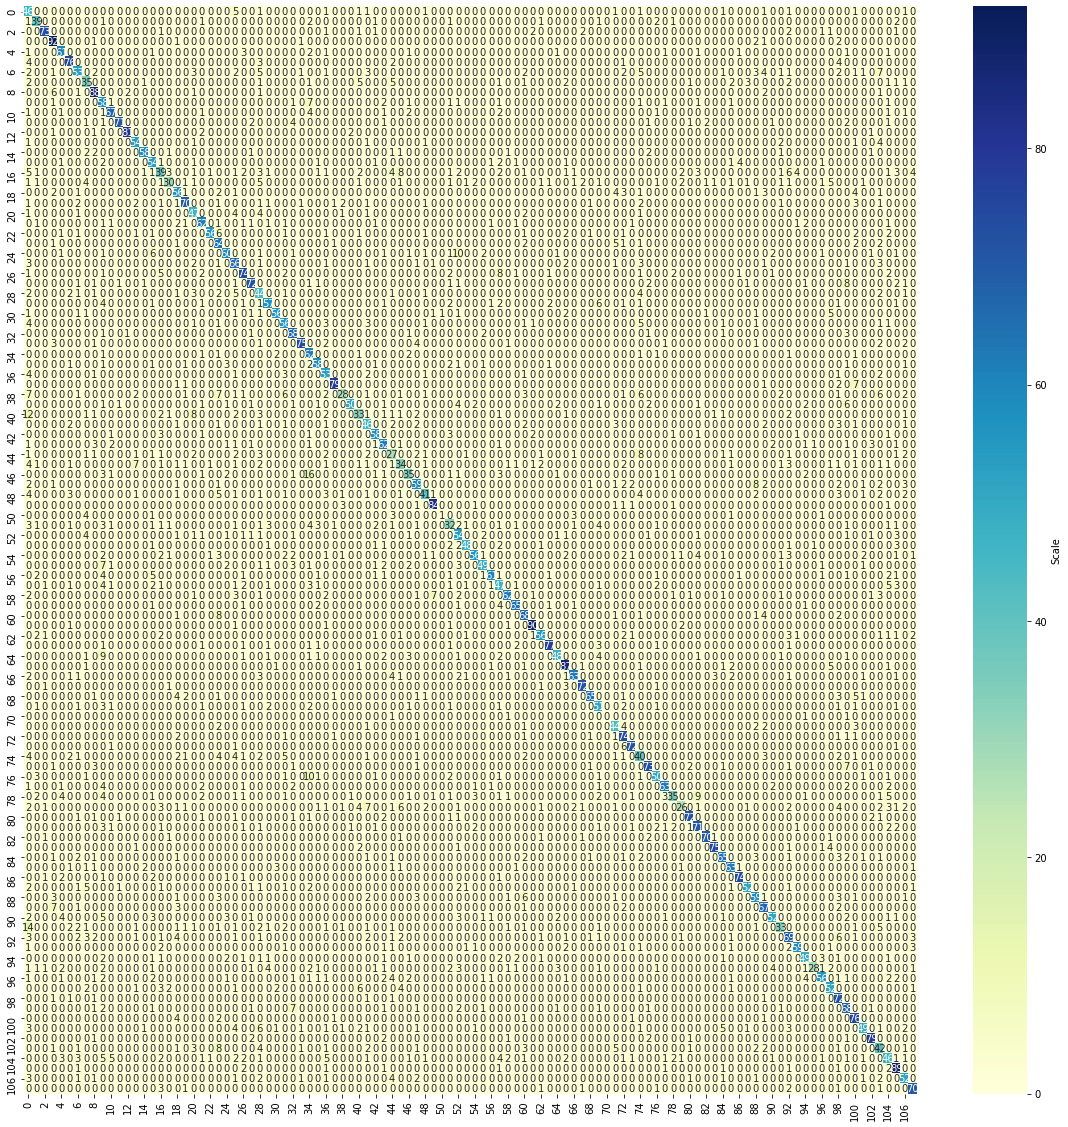

In [45]:
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Predict the test set
y_pred = model.predict(X_test)

# Collapse to one column to align with the test set.
y_cpred = np.argmax(y_pred, axis=1)

# Get confusion matrix
cmatrix = confusion_matrix(y_test, y_cpred)

# plot the confusion matrix
fig = plt.figure(figsize=(20,20))
ax = seaborn.heatmap(cmatrix, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
plt.show()

In [48]:
from sklearn.metrics import classification_report

# Calculate FMR and FNMR for each subject then average
FP = cmatrix.sum(axis=0) - np.diag(cmatrix)  
FN = cmatrix.sum(axis=1) - np.diag(cmatrix)
TP = np.diag(cmatrix)
TN = cmatrix.sum() - (FP + FN + TP)

XP = (FP+TP)
idx = np.nonzero(XP)
FMR = FP[idx]/(FP[idx]+TP[idx])

XP = (FN+TP)
idx = np.nonzero(XP)
FNMR = FN[idx]/(FN[idx]+TP[idx])

print(classification_report(y_test, y_cpred))

# Output the data
print('Average FMR:',np.mean(FMR))
print('    Min FMR:',np.min(FMR))
print('    Max FMR:',np.max(FMR))
print()
print('Average FNMR:',np.mean(FNMR))
print('    Min FNMR:',np.min(FNMR))
print('    Max FNMR:',np.max(FNMR))

              precision    recall  f1-score   support

           0       0.29      0.73      0.42        63
           1       0.71      0.74      0.72        53
           2       0.91      0.85      0.88        86
           3       0.75      0.92      0.83       100
           4       0.74      0.80      0.77        76
           5       0.80      0.84      0.82        90
           6       0.65      0.51      0.58       103
           7       0.51      0.54      0.53        65
           8       0.75      0.86      0.80       102
           9       0.41      0.73      0.53        79
          10       0.80      0.81      0.80        83
          11       0.95      0.81      0.87        88
          13       0.96      0.92      0.94        88
          14       0.75      0.83      0.79        65
          15       0.91      0.82      0.86        71
          16       0.61      0.75      0.67        72
          17       0.50      0.36      0.42       107
          18       0.73    